#Course 04

##Week - 02

###Code snipets to understand the creation of sequence datasets

In [0]:
!pip install tensorflow==2.0.0-beta0

     |████████████████████████████████| 87.9MB 35kB/s 
     |████████████████████████████████| 501kB 43.8MB/s 
     |████████████████████████████████| 3.1MB 19.2MB/s 
  Found existing installation: tensorflow 2.2.0rc3
    Uninstalling tensorflow-2.2.0rc3:
      Successfully uninstalled tensorflow-2.2.0rc3


In [0]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta0


The Target of the function is as below : 

In [0]:
''' 
Xs = [1,2,3,4,5,6,7,,8,9,10]

window_size = 4
batch_size = 3

Ys  =  [ [ 
           [1,2,3,4][5] ,
           [2,3,4,5][6] ,
           [3,4,5,6][7]   
         ],
         [ [4,5,6,7][8] , 
           [5,6,7,8][9] , 
           [6,7,8,9][10]  
         ]    
       ]
'''

' \nXs = [1,2,3,4,5,6,7,,8,9,10]\n\nwindow_size = 4\nbatch_size = 3\n\nYs  =  [ [ \n           [1,2,3,4][5] ,\n           [2,3,4,5][6] ,\n           [3,4,5,6][7]   \n         ],\n         [ [4,5,6,7][8] , \n           [5,6,7,8][9] , \n           [6,7,8,9][10]  \n         ]    \n       ]\n'

In [0]:
dataset = tf.data.Dataset.range(10)
print(type(dataset))

for i in dataset:
  print(i.numpy())

<class 'tensorflow.python.data.ops.dataset_ops.RangeDataset'>
0
1
2
3
4
5
6
7
8
9


In [0]:
## you can actually use windowing for this datasets :

dataset = tf.data.Dataset.range(10)

dataset = dataset.window(5,shift = 1)

print(type(dataset))

for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy() ,end = ' ')
  print()

<class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [0]:

dataset = tf.data.Dataset.range(10).window( 5 , shift = 1 , drop_remainder = True)

print(type(dataset))

for x in dataset:

  for i in x:

    print(i.numpy() ,end = ' ')
    
  print()

<class 'tensorflow.python.data.ops.dataset_ops.WindowDataset'>
0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [0]:
dataset = tf.data.Dataset.range(10).window( 5 , shift = 1 , drop_remainder = True)

dataset = dataset.flat_map(lambda window : window.batch(5))

for i in dataset:
  print(i.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


Create the X and Y from the datasets :

In [0]:
dataset = tf.data.Dataset.range(10).window( 5 , shift = 1 , drop_remainder = True)

dataset = dataset.flat_map(lambda window : window.batch(5))

dataset = dataset.map(lambda window:(window[:-1],window[-1:]))

for x,y in dataset:
  print(x.numpy(),y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [0]:
dataset = tf.data.Dataset.range(10).window( 5 , shift = 1 , drop_remainder = True)

dataset = dataset.flat_map(lambda window : window.batch(5))

dataset = dataset.map(lambda window:(window[:-1],window[-1:]))

dataset = dataset.shuffle(buffer_size = 10 )

for x,y in dataset:
  print("Type of X : ",type(x))
  print('Type of Y : ',type(y))
  break

for x,y in dataset:
  print(x.numpy(),y.numpy())

Type of X :  <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of Y :  <class 'tensorflow.python.framework.ops.EagerTensor'>
[3 4 5 6] [7]
[2 3 4 5] [6]
[4 5 6 7] [8]
[5 6 7 8] [9]
[1 2 3 4] [5]
[0 1 2 3] [4]


In [0]:
dataset = tf.data.Dataset.range(10).window( 5 , shift = 1 , drop_remainder = True)

dataset = dataset.flat_map(lambda window : window.batch(5))

dataset = dataset.map(lambda window:(window[:-1],window[-1:]))

dataset = dataset.shuffle(buffer_size = 10 )

dataset = dataset.batch(2).prefetch(1)

for x,y in dataset:
  print("X = ",x.numpy())
  print("Y = ",y.numpy())

X =  [[0 1 2 3]
 [3 4 5 6]]
Y =  [[4]
 [7]]
X =  [[1 2 3 4]
 [4 5 6 7]]
Y =  [[5]
 [8]]
X =  [[5 6 7 8]
 [2 3 4 5]]
Y =  [[9]
 [6]]


### Now lets Create an end-2-end model for the series prediction :

Function for designing a series and plotting it :

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format = "-", start = 0, end = None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude = 1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

#-----------------------------------Create the series----------------------------

series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

#------------------------------------Update with noise---------------------------
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

# EXPECTED OUTPUT
# Chart as in the screencast. First should have 5 distinctive 'peaks'

Function for windowing and then creating the Train Test sets for the model :


In [0]:
## lets now define a function that will give the same output from a series as depicted above;

def windowed_dataset(series , window_size , batch_size , buffer_size):

  #create the dataset;
  dataset = tf.data.Dataset.from_tensor_slices(series)

  #window the dataset;
  dataset = dataset.window(window_size + 1 , shift = 1 , drop_remainder = True)

  #lets now flatten the datset 
  dataset = dataset.flat_map( lambda window : window.batch(window_size + 1))

  # shuffle the data ;
  dataset  =  dataset.shuffle(buffer_size)

  #create x  and y now from the dataset:
  dataset = dataset.map(lambda window : (window[:-1],window[-1]))

  #dive the data into batches :
  dataset = dataset.batch(batch_size).prefetch(1)

  return dataset

In [0]:
''' 
Xs = [1,2,3,4,5,6,7,,8,9,10]

window_size = 4
batch_size = 3

Ys  =  [ [ 
           [1,2,3,4][5] ,
           [2,3,4,5][6] ,
           [3,4,5,6][7]   
         ],
         [ [4,5,6,7][8] , 
           [5,6,7,8][9] , 
           [6,7,8,9][10]  
         ]    
       ]
'''

' \nXs = [1,2,3,4,5,6,7,,8,9,10]\n\nwindow_size = 4\nbatch_size = 3\n\nYs  =  [ [ \n           [1,2,3,4][5] ,\n           [2,3,4,5][6] ,\n           [3,4,5,6][7]   \n         ],\n         [ [4,5,6,7][8] , \n           [5,6,7,8][9] , \n           [6,7,8,9][10]  \n         ]    \n       ]\n'

Divide the data into Train and Test 

In [0]:
time = np.arange(4*365 + 1)

split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_test =  time[split_time:]
x_test = series[:split_time]

Create the dataset from the series that we developed :

series --->  xtrain  ----> dataset from x_train

In [0]:
window_size = 20 
batch_size = 32 
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train , window_size , batch_size , shuffle_buffer_size)

print(type(dataset))


<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


A simple Linear Model :

In [0]:
l0 = tf.keras.layers.Dense(units = 1, input_shape = [window_size])
model = tf.keras.models.Sequential([l0])

Compile and Train the Model 

In [0]:
model.compile(loss = 'mse' , optimizer = tf.keras.optimizers.SGD(lr = 1e-6,momentum = 0.9))

history = model.fit(dataset,epochs = 100 , verbose = 1 )

Epoch 1/100
31/31 [==============================] - 0s 16ms/step - loss: 249.5240
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 116.8513
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 93.5359
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 81.1416
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 73.1235
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 67.3200
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 63.0179
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 59.6841
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 56.9877
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 54.7270
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 52.7747
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 51.0493
Epoch 13/100
31/31 [==

Analyze the learned Weights :

In [0]:
# lets print the weights learned :

print("Layer Weights : {}".format(l0.get_weights()))

Layer Weights : [array([[ 0.06202153],
       [-0.18669045],
       [ 0.09902078],
       [ 0.26854992],
       [-0.21127729],
       [-0.03205363],
       [ 0.13335133],
       [-0.18961889],
       [ 0.02438546],
       [ 0.18106692],
       [-0.22537825],
       [ 0.17000811],
       [-0.02073577],
       [-0.115026  ],
       [-0.01770881],
       [ 0.00462295],
       [ 0.06351702],
       [ 0.21270286],
       [ 0.2969254 ],
       [ 0.47720593]], dtype=float32), array([0.02401186], dtype=float32)]


Use the Model to make some predictions

In [0]:
# a code for the prediction :

print(series[1:21])
print('\n')
print(series[1:21][np.newaxis])
print('\n')
model.predict(series[1:21][np.newaxis])

[49.660896 51.025326 52.424427 48.415695 47.780396 50.633144 48.099857
 44.583878 45.43716  42.13009  40.71074  40.59698  34.648506 33.284378
 33.772278 30.944027 31.588247 27.05832  23.896534 27.439226]


[[49.660896 51.025326 52.424427 48.415695 47.780396 50.633144 48.099857
  44.583878 45.43716  42.13009  40.71074  40.59698  34.648506 33.284378
  33.772278 30.944027 31.588247 27.05832  23.896534 27.439226]]




array([[27.425848]], dtype=float32)

lets predict for the series values 

In [0]:
#code for the generalised output ;

forecast = []

# we make prediction for the entire series :
# but while checking performance take into consideration only the x_text part 
for i in range(len(series) - window_size):
  forecast.append(model.predict(series[i:i+window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:,0,0]

print(len(forecast))
print(len(results))

461
461


Lets plot the predicted vs actual 

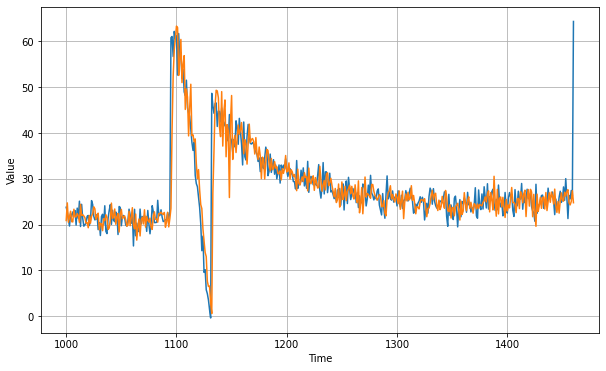

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time[split_time:], series[split_time:])
plot_series(time[split_time:], results[:])
plt.show()

Calculate the error value

In [0]:
tf.keras.metrics.mean_absolute_error(series[split_time:] ,results[:]).numpy()

2.7249653

Develop a Deep Neural Network for the same Dataset :

In [0]:
window_size = 20 
batch_size = 32 
shuffle_buffer_size = 1000

dataset = windowed_dataset(x_train , window_size , batch_size , shuffle_buffer_size)

In [0]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10 , input_shape = [window_size],activation = 'relu'),
                                    tf.keras.layers.Dense(15 , activation = 'relu'),
                                    tf.keras.layers.Dense(1)
])

model.compile(loss = 'mse' , optimizer = tf.keras.optimizers.SGD(lr = 1e-6,momentum = 0.9))

history = model.fit(dataset,epochs = 200 , verbose = 1)

Epoch 1/200
31/31 [==============================] - 0s 15ms/step - loss: 146.6240
Epoch 2/200
31/31 [==============================] - 0s 5ms/step - loss: 65.2110
Epoch 3/200
31/31 [==============================] - 0s 5ms/step - loss: 56.1226
Epoch 4/200
31/31 [==============================] - 0s 5ms/step - loss: 50.2459
Epoch 5/200
31/31 [==============================] - 0s 5ms/step - loss: 45.5556
Epoch 6/200
31/31 [==============================] - 0s 5ms/step - loss: 41.9892
Epoch 7/200
31/31 [==============================] - 0s 5ms/step - loss: 39.1936
Epoch 8/200
31/31 [==============================] - 0s 5ms/step - loss: 36.8586
Epoch 9/200
31/31 [==============================] - 0s 5ms/step - loss: 34.9016
Epoch 10/200
31/31 [==============================] - 0s 5ms/step - loss: 33.2724
Epoch 11/200
31/31 [==============================] - 0s 5ms/step - loss: 31.8861
Epoch 12/200
31/31 [==============================] - 0s 5ms/step - loss: 30.6688
Epoch 13/200
31/31 [===

In [0]:
#code for the generalised output ;

forecast = []

# we make prediction for the entire series :
# but while checking performance take into consideration only the x_text part 
for i in range(len(series) - window_size):
  forecast.append(model.predict(series[i:i+window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:,0,0]

print(len(forecast))
print(len(results))

461
461


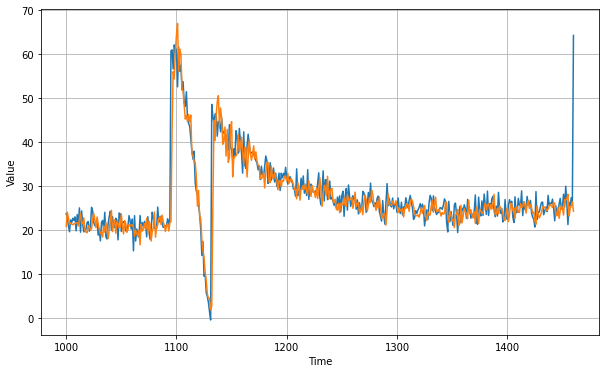

In [0]:
plt.figure(figsize=(10, 6))
plot_series(time[split_time:], series[split_time:])
plot_series(time[split_time:], results[:])
plt.show()

In [0]:
tf.keras.metrics.mean_absolute_error(series[split_time:] ,results[:]).numpy()

2.485035

###Model with the adjustable Learning Rate optimizer 

In [0]:
model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10 , input_shape = [window_size],activation = 'relu'),
                                    tf.keras.layers.Dense(15 , activation = 'relu'),
                                    tf.keras.layers.Dense(1)
])

In [0]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch : 1e-8 * 10**(epoch/20))

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs ={}):
    if logs.get('accuracy') > .99 :
      print("\nterminating the training as accuracy has reached 99 percent")
      self.model.stop_training = True

callbacks_1 = myCallback()

In [0]:
model.compile(loss = 'mse' , optimizer = tf.keras.optimizers.SGD(lr = 1e-8 , momentum = 0.9))

history = model.fit(dataset , epochs = 100 , callbacks = [lr_schedule] ,verbose = 1)

Epoch 1/100
31/31 [==============================] - 0s 16ms/step - loss: 497.6036
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 463.8171
Epoch 3/100
31/31 [==============================] - 0s 5ms/step - loss: 429.5232
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 397.9264
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 368.9909
Epoch 6/100
31/31 [==============================] - 0s 5ms/step - loss: 342.7321
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 318.1892
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 294.5937
Epoch 9/100
31/31 [==============================] - 0s 5ms/step - loss: 271.9925
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 250.3132
Epoch 11/100
31/31 [==============================] - 0s 5ms/step - loss: 229.5742
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 209.6770
Epoch 13/100

Let snow plot the loss wrt the learning rates :

(1e-08, 0.001, 0.0, 300.0)

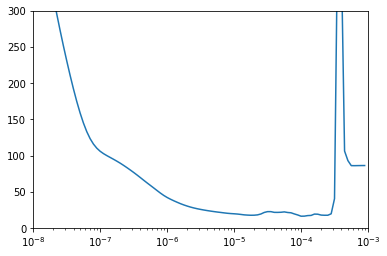

In [0]:
lrs = 1e-8 *(10**(np.arange(100)/20))
plt.semilogx(lrs,history.history['loss'])
plt.axis([1e-8,1e-3,0,300])

So minimum loss occured between 0.0010 - 0.0001 so we will train now with 0.0005

In [0]:
#update teh window size to 30 from 25
window_size = 30 

dataset = windowed_dataset(x_train , window_size , batch_size , shuffle_buffer_size)

model = tf.keras.models.Sequential([
                                    tf.keras.layers.Dense(10 , input_shape = [window_size],activation = 'relu'),
                                    tf.keras.layers.Dense(15 , activation = 'relu'),
                                    tf.keras.layers.Dense(1)
])

model.compile(loss = 'mse' , optimizer = tf.keras.optimizers.SGD(lr = 0.0005 , momentum = 0.9))

history = model.fit(dataset,epochs = 500 , verbose = 1)

Epoch 1/500
31/31 [==============================] - 0s 16ms/step - loss: 4136.4698
Epoch 2/500
31/31 [==============================] - 0s 6ms/step - loss: 378.7148
Epoch 3/500
31/31 [==============================] - 0s 6ms/step - loss: 233.9785
Epoch 4/500
31/31 [==============================] - 0s 6ms/step - loss: 159.3550
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 121.9412
Epoch 6/500
31/31 [==============================] - 0s 5ms/step - loss: 103.2155
Epoch 7/500
31/31 [==============================] - 0s 5ms/step - loss: 93.8393
Epoch 8/500
31/31 [==============================] - 0s 5ms/step - loss: 89.1407
Epoch 9/500
31/31 [==============================] - 0s 5ms/step - loss: 86.7835
Epoch 10/500
31/31 [==============================] - 0s 5ms/step - loss: 85.5990
Epoch 11/500
31/31 [==============================] - 0s 5ms/step - loss: 85.0025
Epoch 12/500
31/31 [==============================] - 0s 5ms/step - loss: 84.7011
Epoch 13/500
31/3

Lets now plot the Loss vs epochs ....

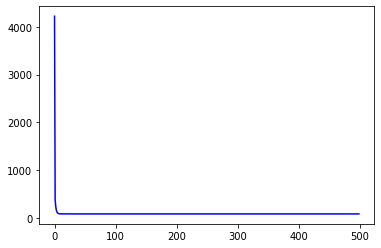

In [0]:
loss = history.history['loss']
epochs = range(len(loss))

plt.plot(epochs , loss , 'b', label  = "Training Loss")
plt.show()

Looks like these many epochs were not required but lets just zoom in :

[85.7210283181102, 85.39408079324309, 85.22348154598905, 85.1331205623666, 85.08436145585837, 85.05743897428218, 85.04218485724066, 85.03328605730509, 85.02793723824098, 85.02462863725485, 85.02252567723855, 85.02115642901549, 85.02024509390606, 85.01963361759776, 85.01921323009373, 85.01892372996537, 85.01872229821903, 85.01858421404337, 85.0184843240325, 85.01841683141964, 85.01836798756393, 85.01833515757139, 85.01831085362386, 85.01829247228878, 85.0182809888702, 85.0182726515937, 85.01826683123087, 85.01826272551547, 85.0182592097017, 85.01825795911022, 85.01825801416771, 85.0182558747911, 85.01825354664597, 85.01825301966716, 85.0182512735583, 85.01825342080028, 85.01825058140706, 85.01825107692443, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 85.01824868585645, 

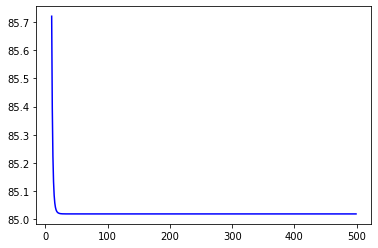

In [0]:
loss = history.history['loss']
epochs = range(10,len(loss))
plot_loss = loss[10:]
print(plot_loss)
print(epochs)
plt.plot(epochs , plot_loss , 'b', label  = "Training Loss")
plt.show()

In [0]:
#code for the generalised output ;

forecast = []

# we make prediction for the entire series :
# but while checking performance take into consideration only the x_text part 
for i in range(len(series) - window_size):
  forecast.append(model.predict(series[i:i+window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:,0,0]

print(len(forecast))
print(len(results))

461
461


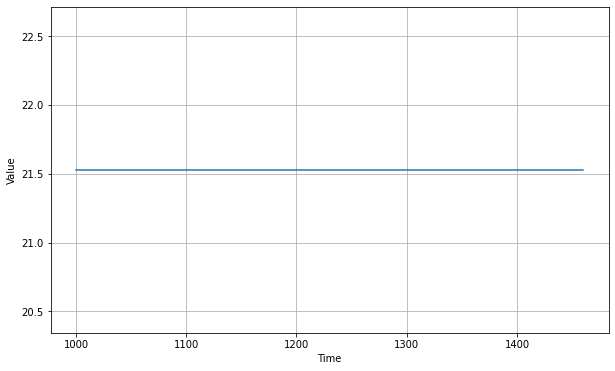

In [0]:
plt.figure(figsize=(10, 6))
#plot_series(time[split_time:], series[split_time:])
plot_series(time[split_time:], results[:])
plt.show()

In [0]:
tf.keras.metrics.mean_absolute_error(series[split_time:] ,results[:]).numpy()

7.1028776

###Exercise 2

Exercise 2 - Predict with a DNN

In class you saw how to split a dataset, and how to start training a DNN using it. For this exercise you’ll create your own synthetic dataset -- I’ve plotted a chart for what it should look like, see if you can figure out the parameters that get this series.

Once you have your series, you’ll create a DNN to predict values for that series!

In [0]:
!pip install tf-nightly-2.0-preview

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.0.0-beta0


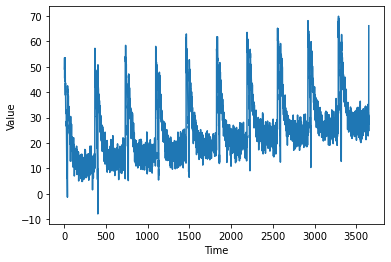

In [0]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * np.pi*6),# YOUR CODE HERE # * np.pi),
                    2 / np.exp(9 * season_time))#YOUR CODE HERE# / np.exp(#YOUR CODE HERE# * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10# YOUR CODE HERE #
series = trend(time, 0.1)# YOUR CODE HERE#)  
baseline = 10
amplitude = 40
slope = 0.005# YOUR CODE HERE#
noise_level = 3# YOUR CODE HERE#

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"),# YOUR CODE HERE #),
    tf.keras.layers.Dense(10, activation="relu"),# YOUR CODE HERE #, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))# YOUR CODE HERE #, optimizer=# YOUR CODE HERE#))
model.fit(dataset,epochs=150,verbose=1)


Epoch 1/150
94/94 [==============================] - 1s 11ms/step - loss: 103.1341
Epoch 2/150
94/94 [==============================] - 1s 6ms/step - loss: 38.0031
Epoch 3/150
94/94 [==============================] - 1s 7ms/step - loss: 32.4822
Epoch 4/150
94/94 [==============================] - 1s 6ms/step - loss: 30.1395
Epoch 5/150
94/94 [==============================] - 1s 6ms/step - loss: 28.7319
Epoch 6/150
94/94 [==============================] - 1s 6ms/step - loss: 27.7577
Epoch 7/150
94/94 [==============================] - 1s 6ms/step - loss: 27.0182
Epoch 8/150
94/94 [==============================] - 1s 6ms/step - loss: 26.4189
Epoch 9/150
94/94 [==============================] - 1s 6ms/step - loss: 25.9345
Epoch 10/150
94/94 [==============================] - 1s 6ms/step - loss: 25.5547
Epoch 11/150
94/94 [==============================] - 1s 6ms/step - loss: 25.2566
Epoch 12/150
94/94 [==============================] - 1s 7ms/step - loss: 25.0030
Epoch 13/150
94/94 [===

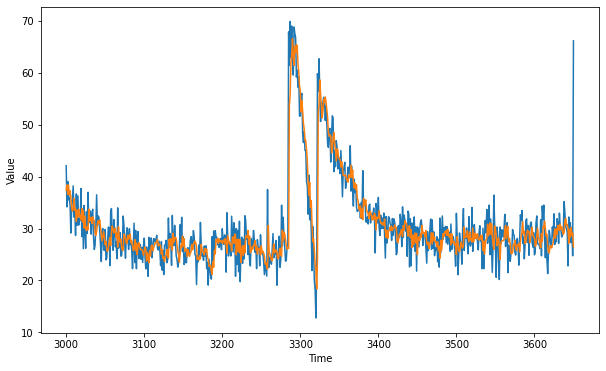

In [0]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [0]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
# EXPECTED OUTPUT
# A Value less than 3

2.9724886